In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd

df = pd.read_csv("data/ExtractedTweets.csv")

democrat = df.query("Party == 'Democrat'").sample(40000)
republican = df.query("Party == 'Republican'").sample(40000)

df_slim = democrat.append(republican)
df_slim.head()
df = df_slim

### Extract tweet information

In [3]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\-.,;:!/?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)

print("Cleaned tweets")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dslh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned tweets


### Lemmatize the text

In [5]:
import spacy
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
print("Lemmatized tweets")

Lemmatized tweets


In [6]:
import gensim

def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)

print("Generated tokens")

Generated tokens


In [7]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)

print("Generated trigrams")

Generated trigrams


### TF-IDF REMOVAL

In [8]:
from gensim.models import TfidfModel
import gensim.corpora as corpora
from sklearn.model_selection import train_test_split

id2word = corpora.Dictionary(df['trigrams'])

# split train and test data to use different lda models later
text_train, text_test, label_train, label_test = train_test_split(df["trigrams"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)

corpus_train = [id2word.doc2bow(text) for text in text_train]
corpus_test = [id2word.doc2bow(text) for text in text_test]
tfidf_train = TfidfModel(corpus_train, id2word=id2word)
tfidf_test = TfidfModel(corpus_test, id2word=id2word)

removed_words  = []
def tf_idf(corpus, tfidf):
    low_value = 0.15
    words_missing_in_tfidf = []
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] # reinitialize to be safe.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for item in drops:
            removed_words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # words with tf-idf score 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
    # remove empty entries
    corpus = [x for x in corpus if x != []]
    return corpus

corpus_train = tf_idf(corpus_train, tfidf_train)
corpus_test = tf_idf(corpus_test, tfidf_test)

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


Text(0.5, 1.0, 'Words removed from individual tweets proportional by their size.')

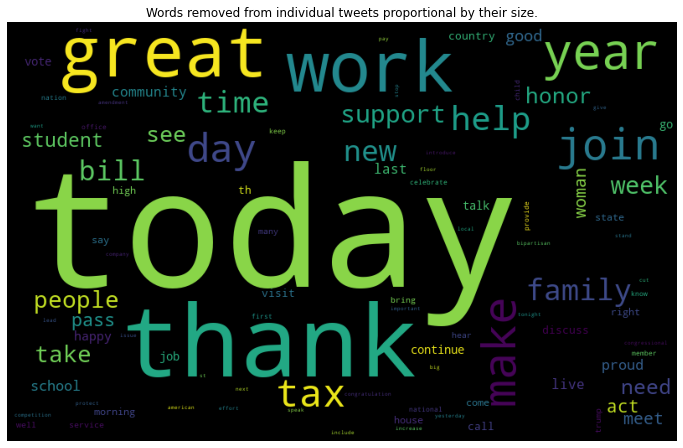

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(collocations=False, width = 800, height = 500).generate(" ".join(removed_words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Words removed from individual tweets proportional by their size.")

In [10]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

In [11]:
import gensim

lda_model_train = gensim.models.LdaMulticore(
                corpus=corpus_train[:-1],
                id2word=id2word,
                num_topics=70,
                random_state=123,
                per_word_topics=False,
                workers=7
            )

lda_model_test = gensim.models.LdaMulticore(
                corpus=corpus_test[:-1],
                id2word=id2word,
                num_topics=70,
                random_state=123,
                per_word_topics=False,
                workers=7
            )

In [ ]:
# get topic vector from trigrams for use as input for classification
text_train = pd.DataFrame(text_train)
text_test = pd.DataFrame(text_test)
text_train['topic_vec'] = text_train['trigrams'].apply(lambda trigram: get_document_topic(lda_model_train, trigram))
text_test['topic_vec'] = text_test['trigrams'].apply(lambda trigram: get_document_topic(lda_model_test, trigram))

Confusion:
 [[6180 5881]
 [5901 6038]]
Accuracy: 0.5090833333333333
Precision: 0.5090665901798483
Recall: 0.5090664113619214
F1Score: 0.5090661472392238


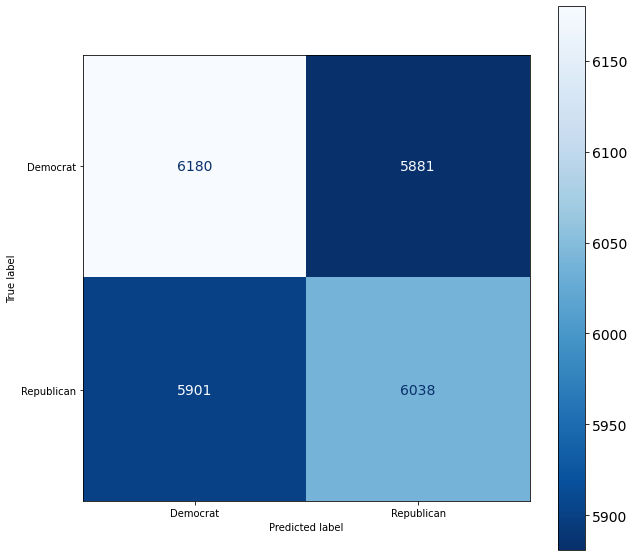

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix

cl = MLPClassifier()

# Train and predict
cl.fit(text_train['topic_vec'].tolist(), label_train)
prediction = cl.predict(text_test['topic_vec'].tolist())

# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion:\n " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))

# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test['topic_vec'].tolist(), label_test, ax=ax_cm, cmap=plt.cm.Blues_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_130.pdf")
plt.show()

In [15]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_train, corpus_train, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
48    -0.003213  0.126054       1        1  2.652729
66    -0.017130  0.021023       2        1  2.017155
42    -0.005743  0.061967       3        1  1.995465
52    -0.094575  0.214482       4        1  1.748988
18     0.199764 -0.046747       5        1  1.722842
...         ...       ...     ...      ...       ...
69     0.054955  0.011779      66        1  1.232353
10    -0.136342 -0.053669      67        1  1.211829
28     0.032895  0.245451      68        1  1.169896
57     0.082817  0.226034      69        1  1.166670
62     0.232772 -0.089369      70        1  1.157156

[70 rows x 5 columns], topic_info=        Term         Freq        Total Category  logprob  loglift
149      tax  2332.000000  2332.000000  Default  30.0000  30.0000
119    honor  1564.000000  1564.000000  Default  29.0000  29.0000
446  student  1583.000000  1583.000000  Default  28.0000  28.0000
30   discuss  1122.000000  1122.000000  Default  27.0000  27.0000
346      day  1769.000000  1769.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
429     read    16.014776   615.323690  Topic70  -5.6191   0.8106
77      year    17.365870  1976.753152  Topic70  -5.5381  -0.2755
26      work    17.075175  2500.277946  Topic70  -5.5550  -0.5273
76      take    16.498508  1355.927906  Topic70  -5.5893   0.0502
540   family    16.512087  1880.252329  Topic70  -5.5885  -0.2759

[5780 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
388       7  0.087560  abandon
388      16  0.116747  abandon
388      23  0.087560  abandon
388      25  0.029187  abandon
388      37  0.466987  abandon
...     ...       ...      ...
4569     53  0.050584      yrs
4569     63  0.252921      yrs
5749     39  0.835061    yucca
7027     44  0.669103     yuma
2401     32  0.605713      zoe

[39366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[49, 67, 43, 53, 19, 14, 62, 37, 41, 56, 52, 44, 12, 26, 3, 46, 68, 47, 16, 50, 27, 69, 1, 48, 4, 55, 57, 45, 61, 42, 66, 24, 65, 23, 22, 15, 40, 51, 60, 34, 13, 28, 32, 25, 10, 17, 59, 35, 20, 64, 18, 30, 38, 6, 54, 33, 21, 7, 9, 36, 39, 31, 8, 5, 2, 70, 11, 29, 58, 63])

In [14]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_test, corpus_test, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
48     0.116382  0.066580       1        1  2.424943
66     0.010267 -0.116885       2        1  1.903792
42     0.063125 -0.005118       3        1  1.901538
0      0.118438 -0.067340       4        1  1.804134
11     0.082818 -0.070849       5        1  1.722796
...         ...       ...     ...      ...       ...
9      0.088367 -0.209191      66        1  1.104747
14    -0.070885  0.204140      67        1  1.085902
39     0.026346 -0.229068      68        1  1.081362
59    -0.225185 -0.058471      69        1  1.041181
54     0.004758  0.222451      70        1  0.993759

[70 rows x 5 columns], topic_info=        Term        Freq       Total Category  logprob  loglift
149      tax  955.000000  955.000000  Default  30.0000  30.0000
446  student  628.000000  628.000000  Default  29.0000  29.0000
28      bill  748.000000  748.000000  Default  28.0000  28.0000
231      job  507.000000  507.000000  Default  27.0000  27.0000
47      time  616.000000  616.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
189    visit    5.148673  339.467121  Topic70  -5.7555   0.4228
67    people    5.583937  609.815319  Topic70  -5.6743  -0.0818
706     look    4.684659  180.980214  Topic70  -5.8499   0.9573
63   support    4.889099  624.915111  Topic70  -5.8072  -0.2392
381   school    4.750914  509.208000  Topic70  -5.8359  -0.0631

[5312 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
13929     26  0.262613            aa
13929     34  0.525225            aa
22083     12  0.406782         aahoa
18487     16  0.454906  abaadvocated
4892      58  0.432597        abando
...      ...       ...           ...
2362      37  0.094290          zone
2362      52  0.094290          zone
2362      57  0.188579          zone
2362      63  0.094290          zone
2362      70  0.094290          zone

[27942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[49, 67, 43, 1, 12, 54, 59, 24, 32, 8, 23, 47, 36, 34, 52, 38, 45, 62, 31, 37, 3, 41, 25, 26, 27, 64, 2, 53, 28, 13, 17, 21, 69, 51, 44, 46, 29, 19, 11, 66, 48, 16, 65, 61, 33, 7, 6, 42, 14, 18, 56, 20, 9, 35, 70, 57, 5, 22, 4, 39, 30, 50, 63, 58, 68, 10, 15, 40, 60, 55])